In [2]:
# First, let's import the needed libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

from datetime import datetime

import wetterdienst
wetterdienst.__version__

from wetterdienst import Settings
from wetterdienst.provider.dwd.observation import DwdObservationRequest
from wetterdienst.metadata.period import Period

# Download function

In [ ]:
def get_climate_data(resolution, station_id=None, start_date=None, end_date=None, variables:list=None, subset='climate_summary', shape='long'):
    settings = Settings(  # default
        ts_shape=shape,  # tidy data
        ts_humanize=True,  # humanized parameters
        ts_convert_units=True  # convert values to SI units
    )

    if (variables == None) or (len(variables) == 0):
        parameters = [(resolution, subset)]
    elif len(variables) == 1:
        parameters = [(resolution, subset, variables[0])]
    elif len(variables) > 1:
        parameters = []
        for variable in variables:
            parameters.append((resolution, subset, variable))
    
    if (start_date != None) and (end_date!=None):
        request = DwdObservationRequest(
            parameters=parameters,
            start_date=start_date,  # if not given timezone defaulted to UTC
            end_date=end_date,  # if not given timezone defaulted to UTC
            settings=settings
        )
    
    else:
        request = DwdObservationRequest(
            parameters=parameters,
            periods = Period.HISTORICAL,
            settings=settings
        )
    
    if station_id != None:
        request = request.filter_by_station_id(station_id=(station_id,))#.all()
    else:
        request = request.all()
    
    meta = request.df.to_pandas()
    values = request.values.all().data_complete.to_pandas()
    
    cols_to_use = list(meta.columns.difference(values.columns))+['station_id']
    data_complete = pd.merge(
        values, meta[cols_to_use], on="station_id"
    ).drop(columns=['end_date', 'start_date', 'dataset'])

    #values = request.df
    return data_complete#values#.to_pandas()

# Würzburg station

In [302]:
würzburg_climate_data = get_climate_data('monthly', 5705, '1996-01-01', '2024-12-31', subset='precipitation_more')
würzburg_meantemp = get_climate_data('monthly', 5705, '1996-01-01', '2024-12-31', ['temperature_air_mean_2m'])
würzburg_precipitation_height = get_climate_data('monthly', 5705, '1996-01-01', '2024-12-31', ['precipitation_height'])
würzburg_meantemp

,station_id,resolution,parameter,date,value,quality,height,latitude,longitude,name,state
0,05705,monthly,temperature_air_mean_2m,1996-01-01 00:00:00+00:00,-2.35,10.0,268.0,49.7704,9.9576,Würzburg,Bayern
1,05705,monthly,temperature_air_mean_2m,1996-02-01 00:00:00+00:00,-1.00,10.0,268.0,49.7704,9.9576,Würzburg,Bayern
2,05705,monthly,temperature_air_mean_2m,1996-03-01 00:00:00+00:00,2.42,10.0,268.0,49.7704,9.9576,Würzburg,Bayern
3,05705,monthly,temperature_air_mean_2m,1996-04-01 00:00:00+00:00,9.45,10.0,268.0,49.7704,9.9576,Würzburg,Bayern
4,05705,monthly,temperature_air_mean_2m,1996-05-01 00:00:00+00:00,12.21,10.0,268.0,49.7704,9.9576,Würzburg,Bayern
...,...,...,...,...,...,...,...,...,...,...,...
343,05705,monthly,temperature_air_mean_2m,2024-08-01 00:00:00+00:00,21.15,9.0,268.0,49.7704,9.9576,Würzburg,Bayern
344,05705,monthly,temperature_air_mean_2m,2024-09-01 00:00:00+00:00,16.13,9.0,268.0,49.7704,9.9576,Würzburg,Bayern
345,05705,monthly,temperature_air_mean_2m,2024-10-01 00:00:00+00:00,11.38,9.0,268.0,49.7704,9.9576,Würzburg,Bayern
346,05705,monthly,temperature_air_mean_2m,2024-11-01 00:00:00+00:00,5.23,9.0,268.0,49.7704,9.9576,Würzburg,Bayern


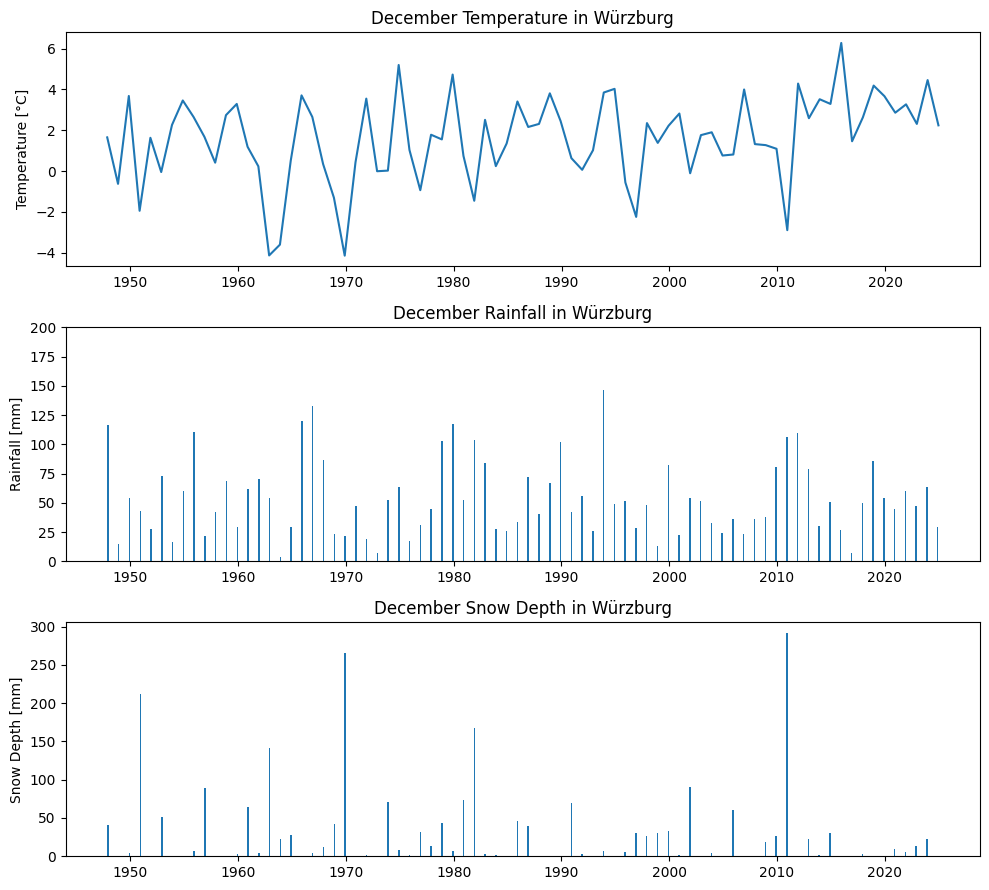

In [283]:
würzburg_snow_depth = get_climate_data('monthly', 5705, subset='precipitation_more', shape='wide')
würzburg_snow_depth['date'] = pd.to_datetime(würzburg_snow_depth['date']).dt.normalize()
#würzburg_snow_depth = würzburg_snow_depth.set_index(pd.to_datetime(würzburg_snow_depth.date)).drop(columns=['date'])

würzburg_temp = get_climate_data('monthly', 5705, variables=['temperature_air_mean_2m'], shape='wide')
würzburg_temp['date'] = pd.to_datetime(würzburg_temp['date']).dt.normalize()
#würzburg_temp = würzburg_temp.set_index(pd.to_datetime(würzburg_temp.date)).drop(columns=['date'])

data_complete = pd.merge(
       würzburg_snow_depth, würzburg_temp, on='date', how='inner'
    )

data_complete_december = data_complete[data_complete['date'].dt.month==12]


fig, ax = plt.subplots(3, 1, figsize=(10, 9))

ax[0].plot(data_complete_december["date"], data_complete_december["temperature_air_mean_2m"])
ax[0].set_title("December Temperature in Würzburg")
ax[0].set_ylabel("Temperature [°C]")


ax[1].bar(
    data_complete_december["date"], data_complete_december["precipitation_height"], align="center", width=50
)
ax[1].set_title("December Rainfall in Würzburg")
ax[1].set_ylabel("Rainfall [mm]")

ax[1].set_ylim(0, 200)

ax[2].bar(
    data_complete_december["date"], data_complete_december["snow_depth"], align="center", width=50
)
ax[2].set_title("December Snow Depth in Würzburg")
ax[2].set_ylabel("Snow Depth [mm]")

#ax[1].set_ylim(0, 200)

plt.tight_layout()
plt.show()

# würzburg_snow_depth[['snow_depth', 'snow_depth_new',
#        'precipitation_height',
#        #'precipitation_height_max'
#        ]].plot()

In [314]:
def plot_climate_stripes(station_id):
    meantemp = get_climate_data('annual', station_id, variables=['temperature_air_mean_2m'], shape='wide').dropna().reset_index()
    meantemp['date'] = pd.to_datetime(meantemp['date']).dt.normalize()

    fig,ax = plt.subplots(figsize=(14, 4))
        
    cmap = 'RdBu_r'

    year = meantemp.date.dt.year
    temp = meantemp['temperature_air_mean_2m']

    start_year = min(year)
    end_year = max(year)

    rect_coll = PatchCollection([Rectangle((y, 0), 1, 1) for y in range(start_year, end_year + 1)], zorder=2)
    rect_coll.set_array(temp)
    rect_coll.set_cmap(cmap)
    ax.add_collection(rect_coll)

    ax.set_ylim(0, 1)
    ax.set_xlim(start_year, end_year + 1)
    ax.yaxis.set_visible(False)
    ax.set_title(meantemp.name[0], fontsize=20, loc='left', y=1.03)

    ax2 = ax.twinx()
    ax2.plot(year, temp, color='black', linewidth=1.5, )
    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position('left')
    ax2.set_ylabel('temperature')

    ax3 = ax2.twinx()
    ax3.set_ylim(ax2.get_ylim())
    ax3.yaxis.set_visible(False)

    coef = np.polyfit(year, temp, 1)
    trend = np.poly1d(coef)
    print(trend[1])
    print(trend[1]*(end_year-start_year))

    ax3.plot(year, trend(year), linestyle='--', color='black', linewidth=1, )

    plt.figtext(0.856, 0.087, '© Clara Vydra', fontsize=6)
    plt.figtext(0.907, 0.15, 'Data source: Deutscher Wetterdienst',
                rotation=270, fontsize=6)

    plotfile = 'plot_warming_stripes_plus_timeseries_and_trend.png'
    fig.savefig(plotfile, bbox_inches='tight', facecolor='white')  

0.025977060913769806
2.000233690360275


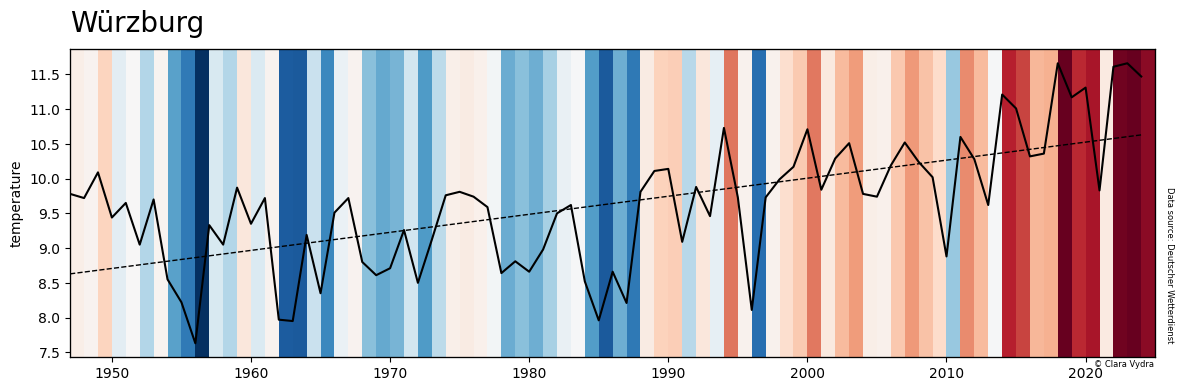

In [315]:
plot_climate_stripes(5705)

1947
0.025977060913769806
2.000233690360275


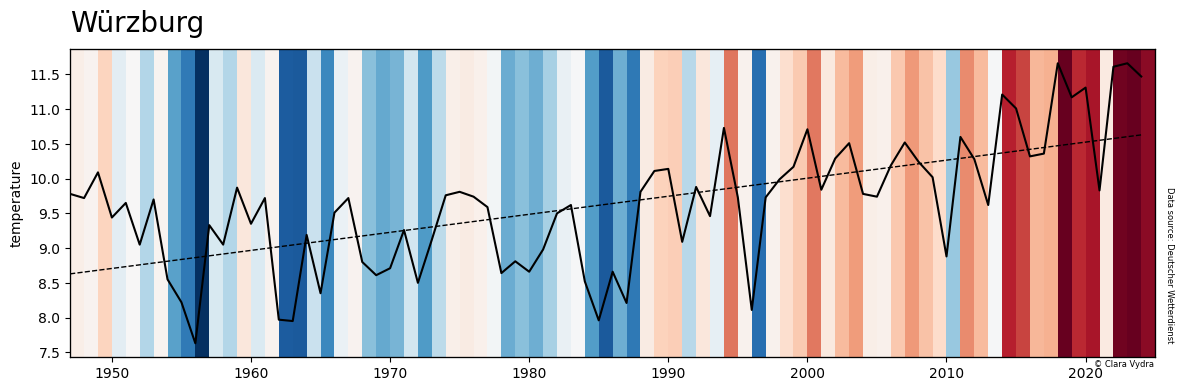

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

meantemp = get_climate_data('annual', 5705, variables=['temperature_air_mean_2m'], shape='wide').dropna()
meantemp['date'] = pd.to_datetime(meantemp['date']).dt.normalize()

fig,ax = plt.subplots(figsize=(14, 4))
    
cmap = 'RdBu_r'

year = meantemp.date.dt.year
temp = meantemp['temperature_air_mean_2m']

start_year = min(year)
print(start_year)
end_year = max(year)

rect_coll = PatchCollection([Rectangle((y, 0), 1, 1) for y in range(start_year, end_year + 1)], zorder=2)
rect_coll.set_array(temp)
rect_coll.set_cmap(cmap)
ax.add_collection(rect_coll)

ax.set_ylim(0, 1)
ax.set_xlim(start_year, end_year + 1)
ax.yaxis.set_visible(False)
ax.set_title('Würzburg', fontsize=20, loc='left', y=1.03)

ax2 = ax.twinx()
ax2.plot(year, temp, color='black', linewidth=1.5, )
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('temperature')

ax3 = ax2.twinx()
ax3.set_ylim(ax2.get_ylim())
ax3.yaxis.set_visible(False)

coef = np.polyfit(year, temp, 1)
trend = np.poly1d(coef)
print(trend[1])
print(trend[1]*(end_year-start_year))

ax3.plot(year, trend(year), linestyle='--', color='black', linewidth=1, )

plt.figtext(0.856, 0.087, '© Clara Vydra', fontsize=6)
plt.figtext(0.907, 0.15, 'Data source: Deutscher Wetterdienst',
            rotation=270, fontsize=6)

plotfile = 'plot_warming_stripes_plus_timeseries_and_trend.png'
fig.savefig(plotfile, bbox_inches='tight', facecolor='white')

1990
0.04782633053221139
1.6260952380951874


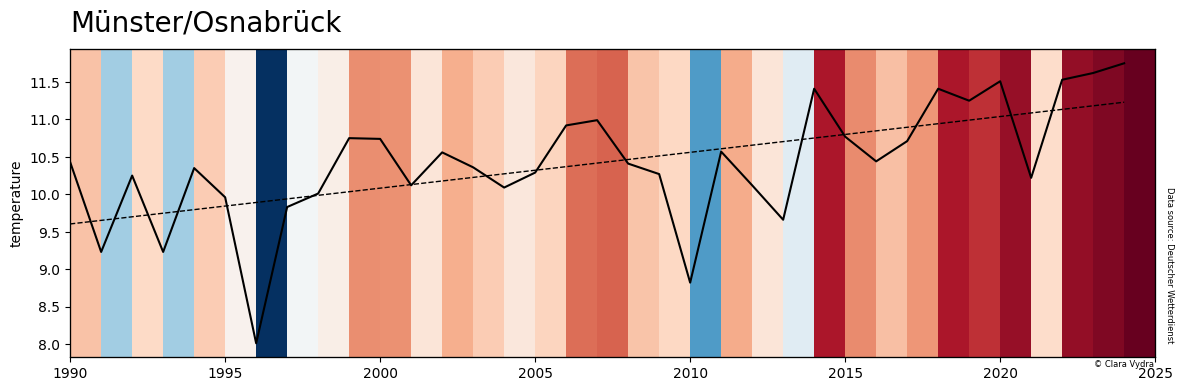

In [301]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

meantemp = get_climate_data('annual', 1766, variables=['temperature_air_mean_2m'], shape='wide').dropna()
meantemp['date'] = pd.to_datetime(meantemp['date']).dt.normalize()

fig,ax = plt.subplots(figsize=(14, 4))
    
cmap = 'RdBu_r'

year = meantemp.date.dt.year
temp = meantemp['temperature_air_mean_2m']

start_year = min(year)
print(start_year)
end_year = max(year)

rect_coll = PatchCollection([Rectangle((y, 0), 1, 1) for y in range(start_year, end_year + 1)], zorder=2)
rect_coll.set_array(temp)
rect_coll.set_cmap(cmap)
ax.add_collection(rect_coll)

ax.set_ylim(0, 1)
ax.set_xlim(start_year, end_year + 1)
ax.yaxis.set_visible(False)
ax.set_title('Münster/Osnabrück', fontsize=20, loc='left', y=1.03)

ax2 = ax.twinx()
ax2.plot(year, temp, color='black', linewidth=1.5, )
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('temperature')

ax3 = ax2.twinx()
ax3.set_ylim(ax2.get_ylim())
ax3.yaxis.set_visible(False)

coef = np.polyfit(year, temp, 1)
trend = np.poly1d(coef)
print(trend[1])
print(trend[1]*(end_year-start_year))

ax3.plot(year, trend(year), linestyle='--', color='black', linewidth=1, )

plt.figtext(0.856, 0.087, '© Clara Vydra', fontsize=6)
plt.figtext(0.907, 0.15, 'Data source: Deutscher Wetterdienst',
            rotation=270, fontsize=6)

plotfile = 'plot_warming_stripes_plus_timeseries_and_trend.png'
fig.savefig(plotfile, bbox_inches='tight', facecolor='white')

1937
0.033659641716540394
2.9283888293390143


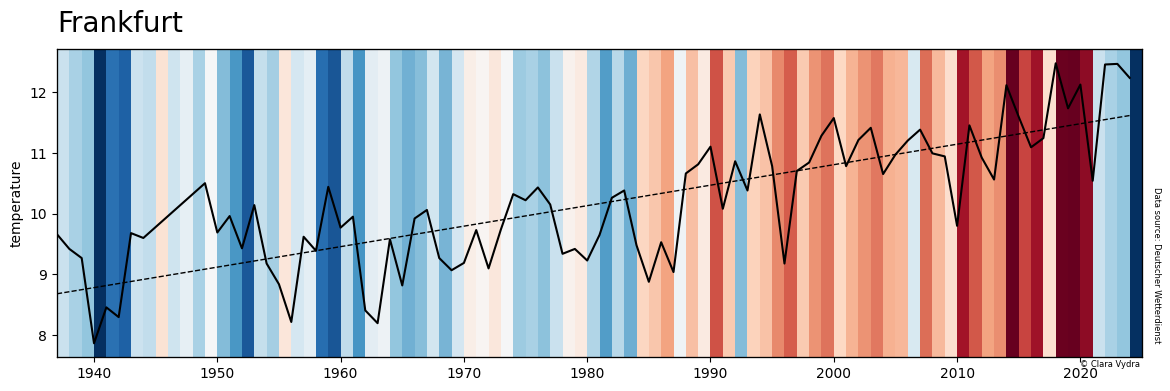

In [296]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

meantemp = get_climate_data('annual', 1420, variables=['temperature_air_mean_2m'], shape='wide').dropna()
meantemp['date'] = pd.to_datetime(meantemp['date']).dt.normalize()

fig,ax = plt.subplots(figsize=(14, 4))
    
cmap = 'RdBu_r'

year = meantemp.date.dt.year
temp = meantemp['temperature_air_mean_2m']

start_year = min(year)
print(start_year)
end_year = max(year)

rect_coll = PatchCollection([Rectangle((y, 0), 1, 1) for y in range(start_year, end_year + 1)], zorder=2)
rect_coll.set_array(temp)
rect_coll.set_cmap(cmap)
ax.add_collection(rect_coll)

ax.set_ylim(0, 1)
ax.set_xlim(start_year, end_year + 1)
ax.yaxis.set_visible(False)
ax.set_title('Frankfurt', fontsize=20, loc='left', y=1.03)

ax2 = ax.twinx()
ax2.plot(year, temp, color='black', linewidth=1.5, )
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('temperature')

ax3 = ax2.twinx()
ax3.set_ylim(ax2.get_ylim())
ax3.yaxis.set_visible(False)

coef = np.polyfit(year, temp, 1)
trend = np.poly1d(coef)
print(trend[1])
print(trend[1]*(end_year-start_year))

ax3.plot(year, trend(year), linestyle='--', color='black', linewidth=1, )

plt.figtext(0.856, 0.087, '© Clara Vydra', fontsize=6)
plt.figtext(0.907, 0.15, 'Data source: Deutscher Wetterdienst',
            rotation=270, fontsize=6)

plotfile = 'plot_warming_stripes_plus_timeseries_and_trend.png'
fig.savefig(plotfile, bbox_inches='tight', facecolor='white')

1993
0.041724706744867696
1.2934659090908986


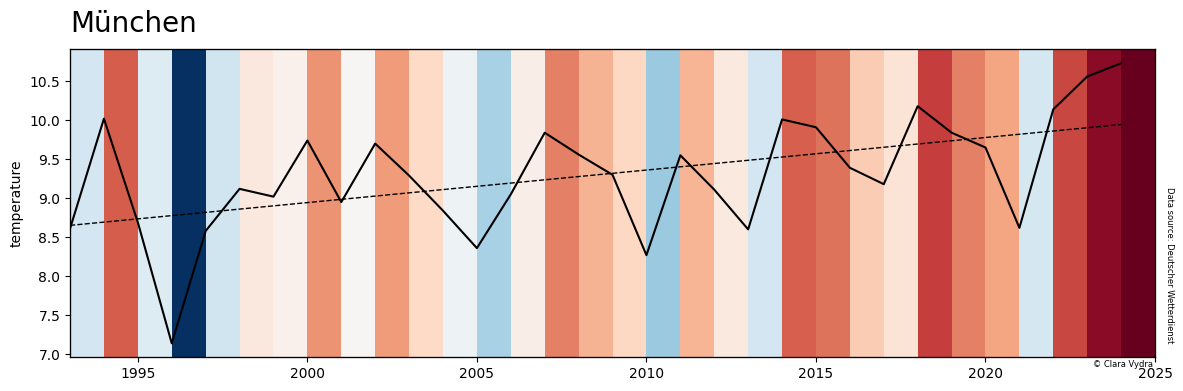

In [295]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

meantemp = get_climate_data('annual', 1262, variables=['temperature_air_mean_2m'], shape='wide').dropna()
meantemp['date'] = pd.to_datetime(meantemp['date']).dt.normalize()

fig,ax = plt.subplots(figsize=(14, 4))
    
cmap = 'RdBu_r'

year = meantemp.date.dt.year
temp = meantemp['temperature_air_mean_2m']

start_year = min(year)
print(start_year)
end_year = max(year)

rect_coll = PatchCollection([Rectangle((y, 0), 1, 1) for y in range(start_year, end_year + 1)], zorder=2)
rect_coll.set_array(temp)
rect_coll.set_cmap(cmap)
ax.add_collection(rect_coll)

ax.set_ylim(0, 1)
ax.set_xlim(start_year, end_year + 1)
ax.yaxis.set_visible(False)
ax.set_title('München', fontsize=20, loc='left', y=1.03)

ax2 = ax.twinx()
ax2.plot(year, temp, color='black', linewidth=1.5, )
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('temperature')

ax3 = ax2.twinx()
ax3.set_ylim(ax2.get_ylim())
ax3.yaxis.set_visible(False)

coef = np.polyfit(year, temp, 1)
trend = np.poly1d(coef)
print(trend[1])
print(trend[1]*(end_year-start_year))

ax3.plot(year, trend(year), linestyle='--', color='black', linewidth=1, )

plt.figtext(0.856, 0.087, '© Clara Vydra', fontsize=6)
plt.figtext(0.907, 0.15, 'Data source: Deutscher Wetterdienst',
            rotation=270, fontsize=6)

plotfile = 'plot_warming_stripes_plus_timeseries_and_trend.png'
fig.savefig(plotfile, bbox_inches='tight', facecolor='white')

1934
0.021656770883046895
1.9491093794742205


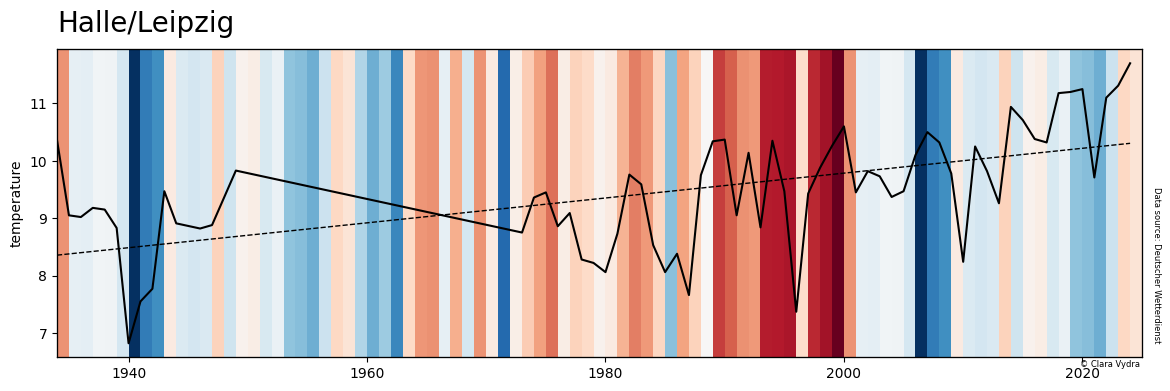

In [300]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

meantemp = get_climate_data('annual', 2932, variables=['temperature_air_mean_2m'], shape='wide').dropna()
meantemp['date'] = pd.to_datetime(meantemp['date']).dt.normalize()

fig,ax = plt.subplots(figsize=(14, 4))
    
cmap = 'RdBu_r'

year = meantemp.date.dt.year
temp = meantemp['temperature_air_mean_2m']

start_year = min(year)
print(start_year)
end_year = max(year)

rect_coll = PatchCollection([Rectangle((y, 0), 1, 1) for y in range(start_year, end_year + 1)], zorder=2)
rect_coll.set_array(temp)
rect_coll.set_cmap(cmap)
ax.add_collection(rect_coll)

ax.set_ylim(0, 1)
ax.set_xlim(start_year, end_year + 1)
ax.yaxis.set_visible(False)
ax.set_title('Halle/Leipzig', fontsize=20, loc='left', y=1.03)

ax2 = ax.twinx()
ax2.plot(year, temp, color='black', linewidth=1.5, )
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('temperature')

ax3 = ax2.twinx()
ax3.set_ylim(ax2.get_ylim())
ax3.yaxis.set_visible(False)

coef = np.polyfit(year, temp, 1)
trend = np.poly1d(coef)
print(trend[1])
print(trend[1]*(end_year-start_year))

ax3.plot(year, trend(year), linestyle='--', color='black', linewidth=1, )

plt.figtext(0.856, 0.087, '© Clara Vydra', fontsize=6)
plt.figtext(0.907, 0.15, 'Data source: Deutscher Wetterdienst',
            rotation=270, fontsize=6)

plotfile = 'plot_warming_stripes_plus_timeseries_and_trend.png'
fig.savefig(plotfile, bbox_inches='tight', facecolor='white')

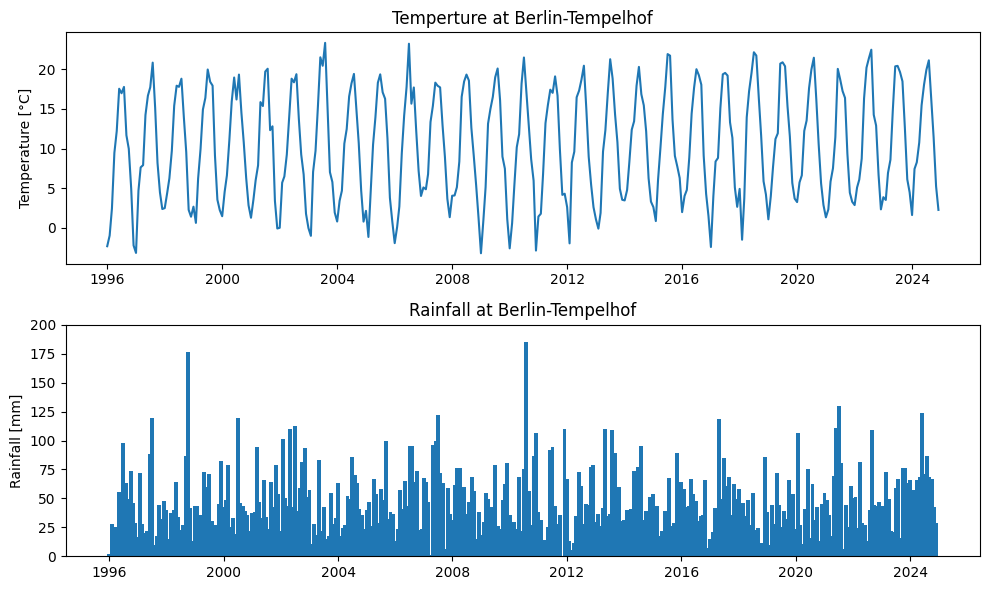

In [187]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].plot(würzburg_meantemp["date"], würzburg_meantemp["value"])
ax[0].set_title("Temperture at Berlin-Tempelhof")
ax[0].set_ylabel("Temperature [°C]")
ax[1].bar(
    würzburg_precipitation_height["date"], würzburg_precipitation_height["value"], align="center", width=50
)
ax[1].set_title("Rainfall at Berlin-Tempelhof")
ax[1].set_ylabel("Rainfall [mm]")

ax[1].set_ylim(0, 200)

plt.tight_layout()
plt.show()

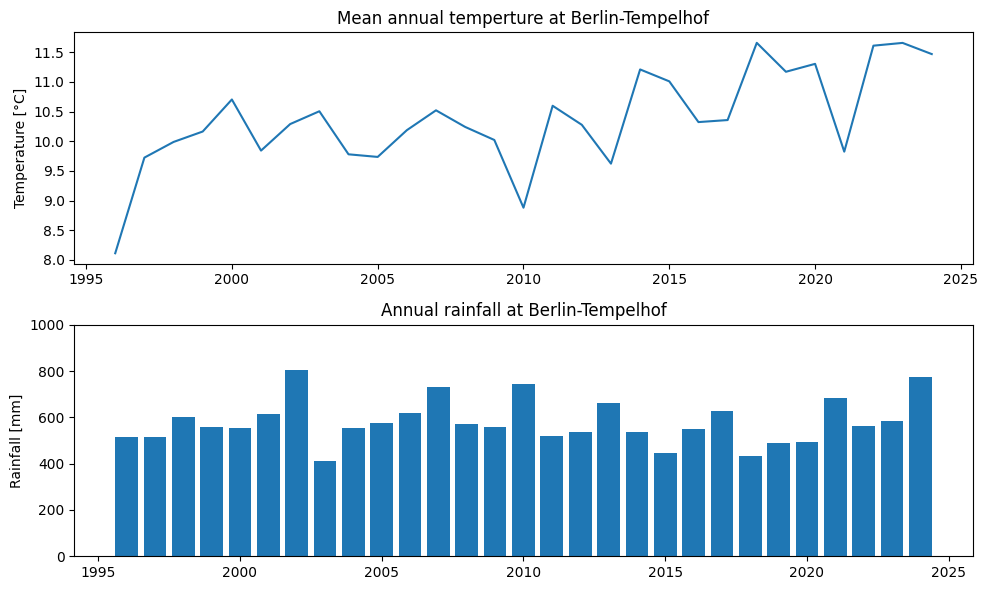

In [188]:
tempelhof_temp_mean = würzburg_meantemp.groupby(würzburg_meantemp["date"].dt.year)[
    "value"
].mean()
tempelhof_rain_mean = würzburg_precipitation_height.groupby(würzburg_precipitation_height["date"].dt.year)[
    "value"
].sum()

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].plot(tempelhof_temp_mean.index, tempelhof_temp_mean.values)
ax[0].set_title("Mean annual temperture at Berlin-Tempelhof")
ax[0].set_ylabel("Temperature [°C]")
ax[1].bar(tempelhof_rain_mean.index, tempelhof_rain_mean.values)
ax[1].set_title("Annual rainfall at Berlin-Tempelhof")
ax[1].set_ylabel("Rainfall [mm]")

ax[1].set_ylim(0, 1000)

plt.tight_layout()
plt.show()

# All stations

In [191]:
all_stations = get_climate_data('monthly', station_id=None, start_date=None, end_date=None, variables=['temperature_air_mean_2m', 'precipitation_height'])

['end_date', 'height', 'latitude', 'longitude', 'name', 'start_date', 'state', 'station_id']


In [ ]:
all_stations_pivot = all_stations.pivot_table(
        index=['station_id', 'resolution', 'dataset', 'date'],
        columns='parameter',
        values='value'
    ).reset_index()

In [96]:
import seaborn as sns
sns.pairplot(
    all_stations_pivot[["height", "temperature_air_mean_2m", "precipitation_height"]]
)

KeyError: "['height'] not in index"

In [77]:
east_data_temp = all_stations[all_stations["parameter"] == "temperature_air_mean_2m"]
east_data_rain = all_stations[all_stations["parameter"] == "precipitation_height"]

# keep specific column
east_data_temp = east_data_temp[["station_id", "date", "value"]]
east_data_rain = east_data_rain[["station_id", "date", "value"]]

# rename "value" column
east_data_temp = east_data_temp.rename(columns={"value": "Temperature"})
east_data_rain = east_data_rain.rename(columns={"value": "Rainfall"})

## merge both dataframes
east_data = pd.merge(
    east_data_temp,
    east_data_rain[["station_id", "date", "Rainfall"]],
    how="outer",
    on=["station_id", "date"],
)

In [78]:
east_data

,station_id,date,Temperature,Rainfall
0,00001,1931-01-01 00:00:00+00:00,-0.5,70.5
1,00001,1931-02-01 00:00:00+00:00,-1.5,51.5
2,00001,1931-03-01 00:00:00+00:00,0.2,79.5
3,00001,1931-04-01 00:00:00+00:00,6.7,44.9
4,00001,1931-05-01 00:00:00+00:00,14.9,65.4
...,...,...,...,...
734657,20007,1934-08-01 00:00:00+00:00,16.3,155.6
734658,20007,1934-09-01 00:00:00+00:00,15.6,33.8
734659,20007,1934-10-01 00:00:00+00:00,9.2,85.2
734660,20007,1934-11-01 00:00:00+00:00,3.7,105.9


In [75]:
annual_east_data = pd.DataFrame()

for i in set(east_data["station_id"]):
    ## aggregate on annual scale for each station
    id_east_data = (
        east_data.loc[east_data["station_id"] == i]
        .groupby(east_data["date"].dt.year)
        .agg({"station_id": "first", "Temperature": "mean", "Rainfall": "sum"})
    )
    id_east_data["date"] = id_east_data.index
    ## append them again to one data frame
    annual_east_data = pd.concat([annual_east_data, id_east_data], ignore_index=True)